# Continuous Bag-Of-Words Neural Network Embedding Training Notebook

This notebook loads review data, cleans and splits it, builds CBOW word embeddings, and exports sentence-level embeddings

In [1]:
import sys
import os
sys.path.append("../")

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from utils.data_utils import load_reviews
from utils.preprocessing import (
clean_text,
tokenize_and_pad,
build_vocab,
CBOWDataset, 
CBOWModel, 
train_cbow,
get_sentence_embedding
)

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vscerra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load and Clean Data

In [2]:
pos_path = "../data/positive_reviews.txt"
neg_path = "../data/negative_reviews.txt"

reviews, labels = load_reviews(pos_path, neg_path)
cleaned_reviews = [clean_text(r) for r in reviews]

In [3]:
# split data into training and test sets
train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    cleaned_reviews, 
    labels, 
    test_size = 0.2, 
    random_state = 42)
print(f"Train size: {len(train_reviews)}, Test size: {len(test_reviews)}")

Train size: 8529, Test size: 2133


## Tokenize and Build Vocabulary

Training set only

In [4]:
#build vocab from training reviews
vocab_to_int, int_to_vocab = build_vocab(train_reviews)

#convert reviews to integer sequences
tokenized_int_train = tokenize_and_pad(train_reviews, vocab_to_int)

## Prepare training dataset for CBOW

In [5]:
context_size = 2 # # of words before and after target word
cbow_dataset = CBOWDataset(tokenized_int_train, context_size)
cbow_loader = DataLoader(cbow_dataset, batch_size = 128, shuffle=True)

## Train CBOW Model

In [8]:
embedding_dim = 100
model = CBOWModel(vocab_size=len(vocab_to_int), embedding_dim=embedding_dim)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# train model and record loss
epochs = 200
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    for context, target in cbow_loader:
        optimizer.zero_grad()
        output = model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(cbow_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} / {epochs}, Loss: {avg_loss:.4f}")
        
#save trained model
torch.save(model.state_dict(), "../model/cbow_model.pth")

Epoch 1 / 200, Loss: 8.5702
Epoch 11 / 200, Loss: 5.1380
Epoch 21 / 200, Loss: 3.9266
Epoch 31 / 200, Loss: 3.1535
Epoch 41 / 200, Loss: 2.6055
Epoch 51 / 200, Loss: 2.1831
Epoch 61 / 200, Loss: 1.8499
Epoch 71 / 200, Loss: 1.5862
Epoch 81 / 200, Loss: 1.3781
Epoch 91 / 200, Loss: 1.2131
Epoch 101 / 200, Loss: 1.0822
Epoch 111 / 200, Loss: 0.9775
Epoch 121 / 200, Loss: 0.8926
Epoch 131 / 200, Loss: 0.8226
Epoch 141 / 200, Loss: 0.7647
Epoch 151 / 200, Loss: 0.7158
Epoch 161 / 200, Loss: 0.6740
Epoch 171 / 200, Loss: 0.6382
Epoch 181 / 200, Loss: 0.6070
Epoch 191 / 200, Loss: 0.5797


## Plot Training Loss

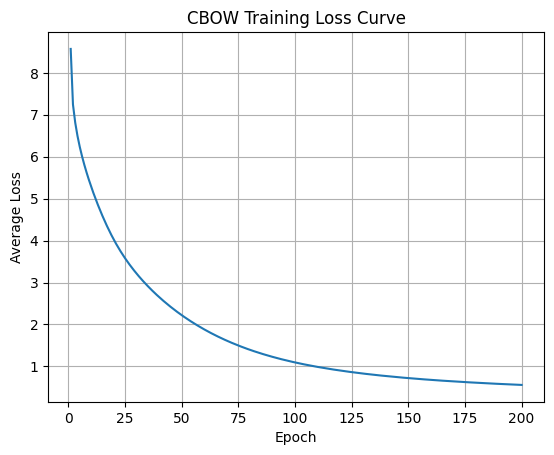

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("CBOW Training Loss Curve")
plt.grid(True)
plt.show()

## Generate and Save Sentence Embeddings

In [11]:
#convert both train and test reviews to int sequences
tokenized_int_test = tokenize_and_pad(test_reviews, vocab_to_int)

#compute mean-over-words embeddings
train_embeddings = [get_sentence_embedding(model, seq) for seq in tokenized_int_train]
test_embeddings = [get_sentence_embedding(model, seq) for seq in tokenized_int_test]

# save embeddings and labels
np.savez("../data/training_embeddings.npz", 
         embeddings=np.array(train_embeddings), 
         labels=np.array(train_labels)
        )

np.savez("../data/test_embeddings.npz", 
         embeddings=np.array(test_embeddings),
         labels=np.array(test_labels)
        )

print("Saved embeddings to ../data/")

Saved embeddings to ../data/
